In [1]:
import os
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [2]:
# Function to load images and labels
def load_data(folder):
    images = []
    labels = []
    boxes  = []
    # Load images
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            images.append(img)
            # Load corresponding XML label
            label_filename = os.path.splitext(filename)[0] + ".xml"
            label_path = os.path.join(folder, label_filename)
            tree = ET.parse(label_path)
            root = tree.getroot()
            # Resize bounding box coordinates
            for obj in root.findall(".//object"):
                label = obj.find("name").text
                bbox = obj.find("bndbox")
                xmin = int(bbox.find("xmin").text)
                ymin = int(bbox.find("ymin").text)
                xmax = int(bbox.find("xmax").text)
                ymax = int(bbox.find("ymax").text)
                # boxes.append([xmin,ymin,xmax,ymax])
                boxes.append(np.squeeze([xmin, ymin, xmax, ymax]))
                labels.append(label)
    return images, labels, boxes



In [3]:
def load_and_resize_data(folder, target_size=(256, 256)):
    images = []
    labels = []
    boxes  = []
    # Load images
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, target_size)
            images.append(img)
            # Load corresponding XML label
            label_filename = os.path.splitext(filename)[0] + ".xml"
            label_path = os.path.join(folder, label_filename)
            tree = ET.parse(label_path)
            root = tree.getroot()
            # Resize bounding box coordinates
            for obj in root.findall(".//object"):
                label = obj.find("name").text
                bbox = obj.find("bndbox")
                xmin = int(bbox.find("xmin").text)
                ymin = int(bbox.find("ymin").text)
                xmax = int(bbox.find("xmax").text)
                ymax = int(bbox.find("ymax").text)
                # Resize coordinates
                xmin = int(xmin * (target_size[0] /640))
                ymin = int(ymin * (target_size[1] /480))
                xmax = int(xmax * (target_size[0] /640))
                ymax = int(ymax * (target_size[1] /480))
                boxes.append(np.squeeze([xmin, ymin, xmax, ymax]))                
                # boxes.append([xmin,ymin,xmax,ymax])
                labels.append(label)

    return images, labels, boxes

In [4]:
# Function to display images with labels
def display_images_with_labels(images, labels, boxes):
    plt.figure(figsize=(15, 5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(f"Label: {labels[i]}")
        xmin, ymin, xmax, ymax  = boxes[i]
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                     linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
    plt.show()



In [5]:
# Set the path to dataset
base_path = r"C:\Users\shahrooz\Documents\HW3NNDL\data"
train_folder = os.path.join(base_path, "train")
test_folder = os.path.join(base_path, "test")
valid_folder = os.path.join(base_path, "valid")

# Load Train images and labels just for figure
train_imagesFull, train_labelsFull, train_boxesFull = load_data(train_folder)
# Load and resize images and labels for each set
train_images, train_labels, train_boxes = load_and_resize_data(train_folder)
test_images, test_labels, test_boxes = load_and_resize_data(test_folder)
valid_images, valid_labels, valid_boxes = load_and_resize_data(valid_folder)

#Check the size of the imported files :
print("Shape of train_images array:", np.array(train_images).shape)
print("Shape of train_labels array:", np.array(train_labels).shape)
print("Shape of train_boxes array:", np.array(train_boxes).shape)
print("Shape of test_images array:", np.array(test_images).shape)
print("Shape of test_labels array:", np.array(test_labels).shape)
print("Shape of test_boxes array:", np.array(test_boxes).shape)
print("Shape of valid_images array:", np.array(valid_images).shape)
print("Shape of valid_labels array:", np.array(valid_labels).shape)
print("Shape of valid_boxes array:", np.array(valid_boxes).shape)

Shape of train_images array: (516, 256, 256, 3)
Shape of train_labels array: (516,)
Shape of train_boxes array: (516, 4)
Shape of test_images array: (74, 256, 256, 3)
Shape of test_labels array: (74,)
Shape of test_boxes array: (74, 4)
Shape of valid_images array: (147, 256, 256, 3)
Shape of valid_labels array: (147,)
Shape of valid_boxes array: (147, 4)


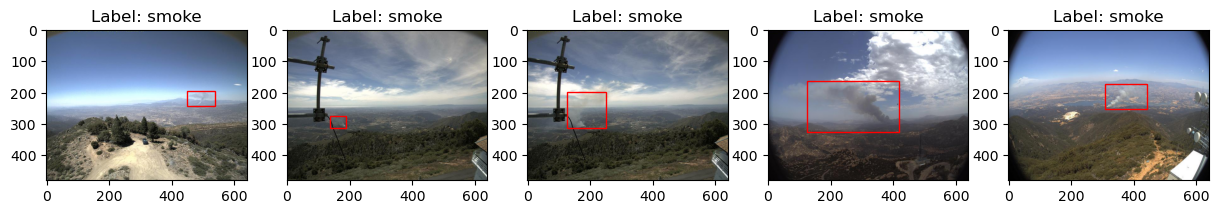

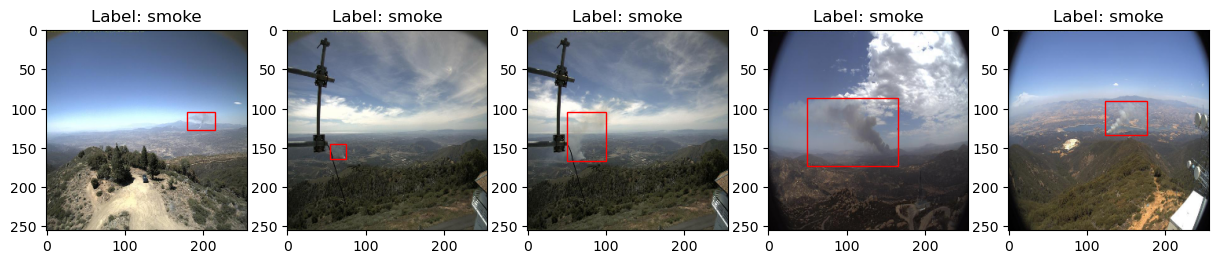

In [6]:
number = 5
display_images_with_labels(train_imagesFull[:number], train_labelsFull[:number],train_boxesFull[:number])
display_images_with_labels(train_images[:number], train_labels[:number],train_boxes[:number])

In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.transforms import functional as F
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [8]:
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, images, labels, boxes):
        self.images = images
        self.labels = labels
        self.boxes = boxes

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])  # Assuming images are numpy arrays
        label = self.labels[idx]
        box = self.boxes[idx]
        # # Ensure that boxes is a list (convert if it's a string)
        # if isinstance(box, str):
        #     box = ast.literal_eval(box)  # Assuming boxes is a string representation of a list

        # # Ensure that box is a list of lists (convert if needed)
        # if not all(isinstance(b, list) for b in box):
        #     box = [box]
        # # Convert the 'boxes' tensor to a list of lists
        # box = box[0].numpy().tolist()

        image = F.to_tensor(image)  # Convert PIL Image to PyTorch tensor
        target = {
            "boxes": torch.tensor([box], dtype=torch.int64),
            "labels": torch.tensor([1], dtype=torch.int64),  

        }

        return image, [target]

In [9]:
# Example usage
# train_images= np.array(train_images)
# train_labels= np.array(train_labels)
# train_boxes= np.array(train_boxes)
# valid_images= np.array(valid_images)
# valid_labels= np.array(valid_labels)
# valid_boxes= np.array(valid_boxes)
# test_images= np.array(test_images)
# test_labels= np.array(test_labels)
# test_boxes= np.array(test_boxes)

train_dataset = CustomDataset(train_images, train_labels, train_boxes)
valid_dataset = CustomDataset(valid_images, valid_labels, valid_boxes)
test_dataset  = CustomDataset(test_images, test_labels, test_boxes)

batch_size = 10
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print the structure of targets for the first few samples
for i in range(min(5, len(train_dataset))):
    image, target = train_dataset[i]
    print(f"Sample {i + 1}:")
    print("  Image Shape:", image.shape)
    print("  Target:", target)
    print("  -------------------------")

Sample 1:
  Image Shape: torch.Size([3, 256, 256])
  Target: [{'boxes': tensor([[179, 104, 215, 128]]), 'labels': tensor([1])}]
  -------------------------
Sample 2:
  Image Shape: torch.Size([3, 256, 256])
  Target: [{'boxes': tensor([[ 55, 145,  75, 165]]), 'labels': tensor([1])}]
  -------------------------
Sample 3:
  Image Shape: torch.Size([3, 256, 256])
  Target: [{'boxes': tensor([[ 50, 105, 100, 167]]), 'labels': tensor([1])}]
  -------------------------
Sample 4:
  Image Shape: torch.Size([3, 256, 256])
  Target: [{'boxes': tensor([[ 49,  87, 166, 173]]), 'labels': tensor([1])}]
  -------------------------
Sample 5:
  Image Shape: torch.Size([3, 256, 256])
  Target: [{'boxes': tensor([[123,  91, 176, 134]]), 'labels': tensor([1])}]
  -------------------------


C:\Users\shahrooz\AppData\Local\Temp\ipykernel_1972\295646568.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  "boxes": torch.tensor([box], dtype=torch.int64),


In [18]:
# Define Faster R-CNN model
num_classes = 2
resnet_backbone = resnet_fpn_backbone('vgg16', pretrained=True)

anchor_generator = AnchorGenerator(
    sizes=((16,), (32,), (64,), (128,), (256,)),
    aspect_ratios=((0.5, 1.0, 2.0),) * 5
)

model = FasterRCNN(
    resnet_backbone,
    num_classes=num_classes,
    rpn_anchor_generator=anchor_generator,
    rpn_pre_nms_top_n_train=6000,
    rpn_nms_thresh=0.7,
)

# Define the optimizer and other necessary components
optimizer = torch.optim.Adam(model.parameters())

# Training loop
num_epochs = 15  # Set the number of epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# ...

# Training loop
for epoch in range(num_epochs):
    model.train()
    for images, targets in train_dataloader:
        images = list(image.to(device) for image in images)
         # Ensure targets is a list
        if not isinstance(targets, list):
            targets = [targets]

        # Print a sample target before the line
        print("Before processing targets:", targets[0] if targets else "No targets")

        # Add a check for target format
        if not all(isinstance(t, dict) for t in targets):
            print("Targets are not in the expected format. Check the data loading process.")
            continue

        # Unpack the list of targets and handle the case of a single target
        targets = [{k: v.squeeze(1).to(device) if k == "boxes" else v.to(device) for k, v in t.items()} for t in targets]
        
        # targets = [{k: v.squeeze(0).to(device) if k == "boxes" else v.to(device) for k, v in t.items()} for t in targets]

        # targets = [{k: v.squeeze(0).to(device) for k, v in t.items()} for t in targets]

        # Print a sample target after the line
        print("After processing targets:", targets[0] if targets else "No targets")

        # Validation loss calculation
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        for images, targets in valid_dataloader:
            images = list(image.to(device) for image in images)
    
            # Ensure targets is a list
            if not isinstance(targets, list):
                targets = [targets]
    
            # Print a sample target before the line
            print("Before processing targets:", targets[0] if targets else "No targets")
    
            # Add a check for target format
            if not all(isinstance(t, dict) for t in targets):
                print("Targets are not in the expected format. Check the data loading process.")
                continue
    
            # Unpack the list of targets and handle the case of a single target
            targets = [{k: v.squeeze(1).to(device) if k == "boxes" else v.to(device) for k, v in t.items()} for t in targets]
    
            # Print a sample target after the line
            print("After processing targets:", targets[0] if targets else "No targets")
    
            # Validation loss calculation
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
    
    # Rest of the code...

    # Print or log the training and validation loss
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {loss.item():.4f}, '
          f'Validation Loss: {loss.item():.4f}')  # Use `loss.item()` for both training and validation loss



IndexError: list index out of range